# Continuous Variables Through Regression Analysis

## Linear Regression

In [1]:
import pandas as pd

# Define the columns we want to load
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

# Load Ames Housing dataset from URL
df = pd.read_csv(
    'http://jse.amstat.org/v19n3/decock/AmesHousing.txt',
    sep='\t',             # Tab-separated file
    usecols=columns       # Only load selected columns
)

# Preview first 5 rows of the dataframe
print(df.head())

   Overall Qual  Overall Cond  Total Bsmt SF Central Air  Gr Liv Area  \
0             6             5         1080.0           Y         1656   
1             5             6          882.0           Y          896   
2             6             6         1329.0           Y         1329   
3             7             5         2110.0           Y         2110   
4             5             5          928.0           Y         1629   

   SalePrice  
0     215000  
1     105000  
2     172000  
3     244000  
4     189900  


In [2]:
df.shape

(2930, 6)

In [3]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [4]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [5]:
# remove the missing value
# Drop rows with missing values
df = df.dropna(axis=0)

# Check if any null values remain in the dataset
print(df.isnull().sum())

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64


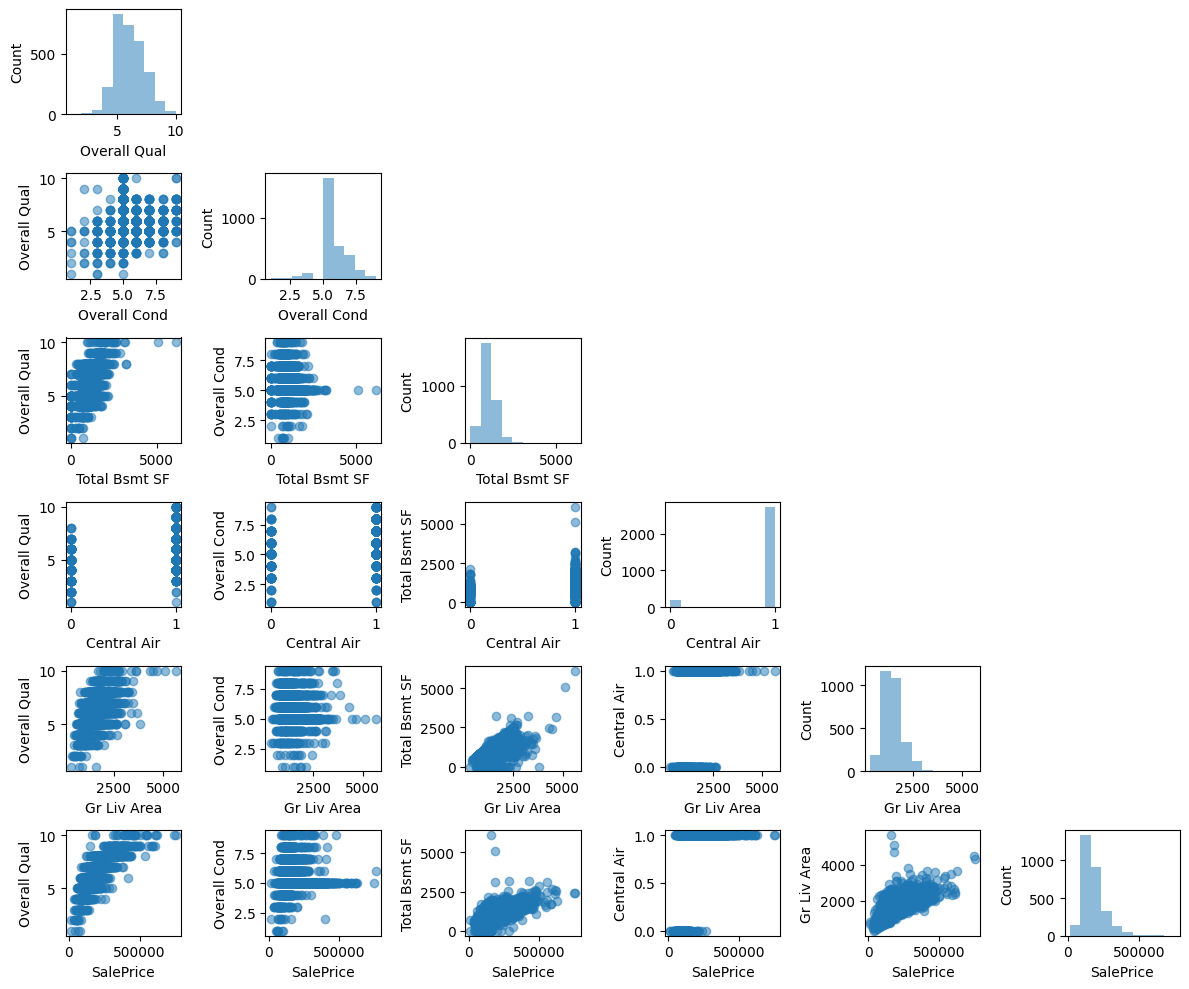

In [6]:
# Exploratory data analysis (EDA) is an important and recommended first step prior to training ML model. 
# First create a scatterplot matrix to visualize the pair-wise corrlations between different features
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix # library that contains various convenience functions for ml and ds

# Create a scatterplot matrix of the DataFrame
scatterplotmatrix(df.values,
                  figsize=(12, 10),     # Figure size
                  names=df.columns,     # Column names for axes
                  alpha=0.5)            # Transparency for points

# Adjust spacing and show plot
plt.tight_layout()
plt.show() # There is somwhat linear relationship between size of living area above ground and sale price

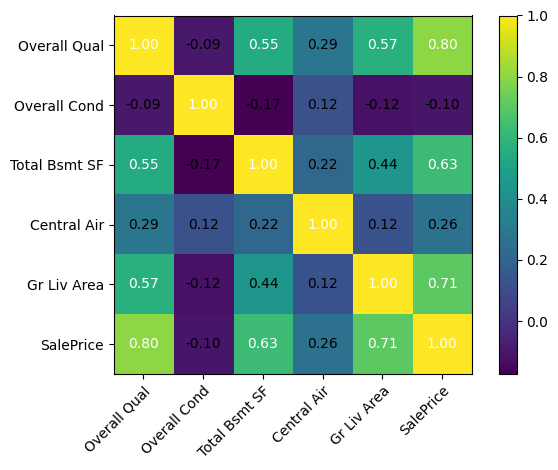

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import heatmap

# Compute the correlation matrix (transpose needed for features)
cm = np.corrcoef(df.values.T)

# Create a heatmap of correlations
hm = heatmap(cm,
             row_names=df.columns,    # Row labels
             column_names=df.columns) # Column labels

# Adjust spacing and show plot
plt.tight_layout()
plt.show() #salesprice shows the largest correlation with GR Liv Area variable with .71

### Solving regression for regression parameters with gradient descent

In [10]:
# Using the GD implementation of Adaline from chapter 2 nd removing the threshold function to implement first linear regression model
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    def predict(self, X):
        return self.net_input(X)

In [11]:
# use the Gr Living Area freature to predict SalesPrice
import numpy as np
from sklearn.preprocessing import StandardScaler

# Extract features (living area) and target (sale price)
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

# Standardize the feature and target
sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()  # flatten target back to 1D

# Train linear regression model using gradient descent
lr = LinearRegressionGD(eta=0.1)  # assumes you defined LinearRegressionGD earlier
lr.fit(X_std, y_std)

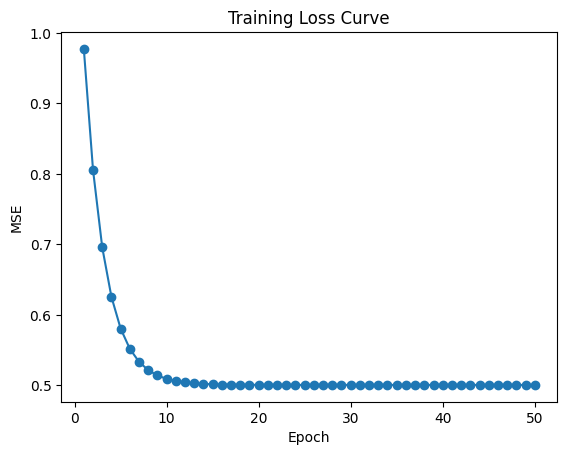

In [12]:
# Always a good idea to plot loss as a function of number of epochs over training dataset when using optimization algos like GD
import matplotlib.pyplot as plt

# Plot the Mean Squared Error (MSE) over epochs from gradient descent training
plt.plot(range(1, lr.n_iter + 1), lr.losses_, marker='o')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('Training Loss Curve')
plt.show()

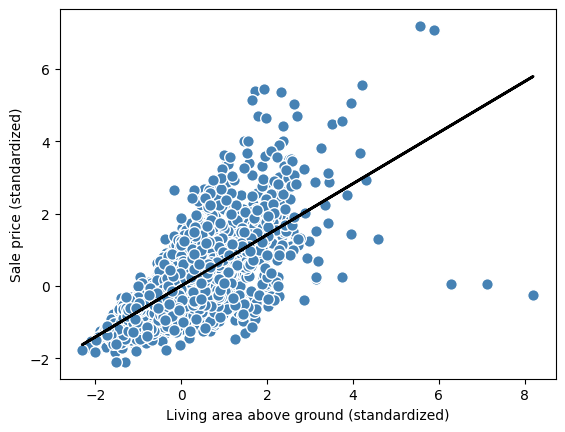

In [ ]:
# Visualize how well linear regression line fits training data by creating helper function that will plot a scatter plot of training exampels and add regression line
def lin_regplot(X, y, model):
    # Scatter plot of feature values (X) vs target values (y)
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)

    # Plot regression line using model predictions
    plt.plot(X, model.predict(X), color='black', lw=2)
    
# use this function to plot living area against sales price
# Plot standardized living area vs. standardized sale price
lin_regplot(X_std, y_std, lr)

# Label axes
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')

# Show the plot
plt.show() # while the observation makes sense, data does show that living area size does not explain house prices well in many cases. Later will discuss how to quantify performance of model
# We can also observe several outliers, which we will deal with later


In [ ]:
# 

# Standardize a new living area value (2500 sq ft)
feature_std = sc_x.transform(np.array([[2500]]))

# Predict sale price using the trained linear regression model
target_std = lr.predict(feature_std)

# Convert prediction back to original scale (inverse transform)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))

# Print the predicted sale price
print(f'Sales price: ${target_reverted.flatten()[0]:.2f}')

Sales price: $292507.07


In [ ]:
# Print the slope (weight for the feature)
print(f"Slope: {lr.w_[0]:.3f}")

# Print the intercept (bias term)
print(f"Intercept: {lr.b_[0]:.3f}") # zero because we standardized the data


Slope: 0.707
Intercept: -0.000


In [ ]:
# Estimating coefficient of regression model via scikit-learn
# Using sciki-learn's linear regression is more efficient and works better with unstandarzied data, so we can skip standardization step
from sklearn.linear_model import LinearRegression

# Create and fit the model
slr = LinearRegression()
slr.fit(X, y)

# Predict target values
y_pred = slr.predict(X)

# Print slope (coefficient for Gr Liv Area)
print(f"Slope: {slr.coef_[0]:.3f}")

# Print intercept (bias term)
print(f"Intercept: {slr.intercept_:.3f}")

Slope: 111.666
Intercept: 13342.979


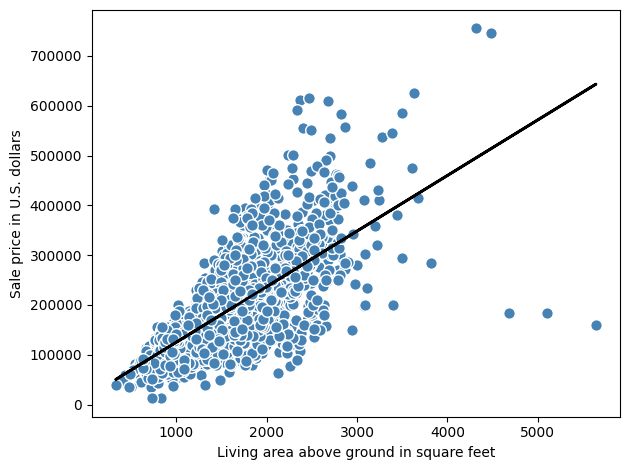

In [ ]:
# Although slope and intercept are different, it still fits data similarly well:
# Plot regression line with actual data points
lin_regplot(X, y, slr)

# Add axis labels
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

# Improve spacing/layout
plt.tight_layout()

# Show the plot
plt.show()

### Fitting robust regression model using RANSAC

In [ ]:
from sklearn.linear_model import LinearRegression, RANSACRegressor

# Create a RANSAC regressor with a LinearRegression base model
ransac = RANSACRegressor(
    # base_estimator=LinearRegression(),  # underlying regression model
    estimator=LinearRegression(), # New version of scikitlearn changed it
    max_trials=100,                     # number of iterations # max number of iterations
    min_samples=0.95,                   # fraction of samples for each trial min number of randomly chosen examples have to be at least 95% of dataset
    residual_threshold=None,            # automatic threshold if None # automatically uses MAD (median absolute deviation)
    random_state=123                    # for reproducibility
)

# Fit RANSAC to the dataset
ransac.fit(X, y)

,estimator,LinearRegression()
,min_samples,0.95
,residual_threshold,None
,is_data_valid,None
,is_model_valid,None
,max_trials,100
,max_skips,inf
,stop_n_inliers,inf
,stop_score,inf
,stop_probability,0.99
,loss,'absolute_error'


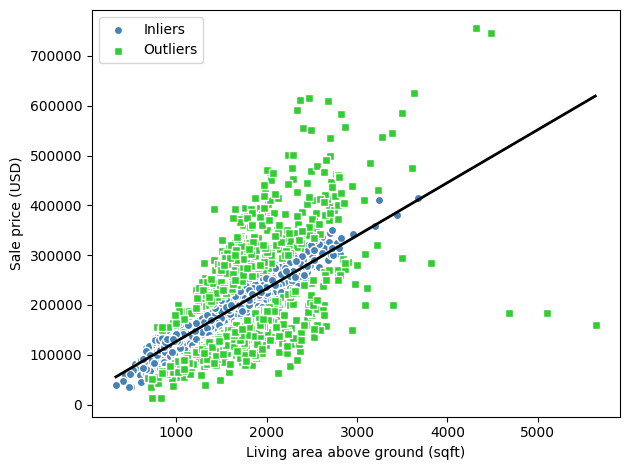

In [20]:
# Once fitted, now lets obtain inliers and outliers and plot them together with linear fit
# Get inliers and outliers
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Generate line for prediction (use full range of X)
line_X = np.arange(X.min(), X.max(), 10)  # step of 10 sqft for smoothness
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

# Plot inliers
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')

# Plot outliers
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')

# Plot regression line
plt.plot(line_X, line_y_ransac, color='black', lw=2)

# Labels and legend
plt.xlabel('Living area above ground (sqft)')
plt.ylabel('Sale price (USD)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
# slope and intercept slightly different
print(f"Slope: {ransac.estimator_.coef_[0]:.3f}")
print(f"Intercept: {ransac.estimator_.intercept_:.3f}")

Slope: 106.348
Intercept: 20190.093


In [ ]:
def median_absolute_deviation(data):
    return np.median(np.abs(data - np.median(data)))

mad = median_absolute_deviation(y)
print(mad) # if we want to identify fewer data points as outliers, can choose residual threshold value greater than preceding MAD

37000.0


### Evaluating the performance of linear regression models